# NYC Citywide Annualized Calendar Sales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

In [2]:
# Prettify
plt.style.use('dark_background')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [3]:
# Load the dataset
df = pd.read_csv('NYC_Citywide_Annualized_Calendar_Sales_Update.csv')

## Data Cleaning

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512833 entries, 0 to 512832
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BOROUGH                          512833 non-null  object 
 1   NEIGHBORHOOD                     512833 non-null  object 
 2   BUILDING CLASS CATEGORY          512833 non-null  object 
 3   TAX CLASS AS OF FINAL ROLL       508762 non-null  object 
 4   BLOCK                            512833 non-null  int64  
 5   LOT                              512833 non-null  int64  
 6   EASE-MENT                        0 non-null       float64
 7   BUILDING CLASS AS OF FINAL ROLL  508762 non-null  object 
 8   ADDRESS                          512833 non-null  object 
 9   APARTMENT NUMBER                 127886 non-null  object 
 10  ZIP CODE                         512806 non-null  float64
 11  RESIDENTIAL UNITS                460425 non-null  float64
 12  CO

In [5]:
print(df.duplicated().sum())

3381


In [6]:
df = df.drop_duplicates()
print(df.duplicated().sum())

0


In [7]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AS OF FINAL ROLL', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AS OF FINAL ROLL', 'ADDRESS', 'APARTMENT NUMBER',
       'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'Latitude', 'Longitude', 'Community Board',
       'Council District', 'Census Tract', 'BIN', 'BBL', 'NTA'],
      dtype='object')

In [8]:
# Drop columns
df.drop(['EASE-MENT','BUILDING CLASS AS OF FINAL ROLL','APARTMENT NUMBER','ADDRESS','TAX CLASS AT TIME OF SALE','BUILDING CLASS AT TIME OF SALE','Latitude','Longitude','Community Board','Council District','Census Tract','BIN','BBL','NTA'], axis=1, inplace=True)
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AS OF FINAL ROLL', 'BLOCK', 'LOT', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'SALE PRICE',
       'SALE DATE'],
      dtype='object')

In [9]:
# Create year sold column
df['YEAR SOLD'] = [x[-4:] for x in df['SALE DATE']]

# Set date as index
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df = df.set_index('SALE DATE')
df.sort_index()

# Set columns to numeric
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,YEAR SOLD
SALE DATE,,,,,,,,,,,,,,,
2019-03-28,1,CHELSEA,21 OFFICE BUILDINGS,4,697,5,10001.0,0.0,8.0,8.0,NaN,NaN,1926.0,43300000,2019
2019-05-23,1,CHELSEA,21 OFFICE BUILDINGS,4,697,23,10001.0,0.0,53.0,53.0,NaN,NaN,1917.0,148254147,2019
2019-03-13,1,CHELSEA,21 OFFICE BUILDINGS,4,700,55,10001.0,1.0,3.0,4.0,NaN,NaN,1910.0,11000000,2019
2019-05-22,1,CHELSEA,21 OFFICE BUILDINGS,4,712,1,10011.0,0.0,30.0,30.0,NaN,NaN,1936.0,591800000,2019
2019-04-01,1,CHELSEA,21 OFFICE BUILDINGS,4,746,64,10011.0,3.0,1.0,4.0,NaN,NaN,1900.0,0,2019


In [10]:
# Cash Transactions Only
df = df[df['SALE PRICE'] > 0 & df['SALE PRICE'].notna()]

# Valid Square Feet Values Only
df = df[df['LAND SQUARE FEET'] > 0]
df = df[df['GROSS SQUARE FEET'] > 0]

# Valid Year Built Only, Restrict Data
df = df[df['YEAR BUILT'] > 2000]

# Create total sqft column
df['TOTAL SQFT'] = df['GROSS SQUARE FEET'] + df['LAND SQUARE FEET']

# Create price / sqft column
df['PRICE PER SQFT'] = df['SALE PRICE'].div(df['TOTAL SQFT'])

In [11]:
# Clean BOROUGH column
borough_lst = ['MANHATTAN','BRONX','BROOKLYN','QUEENS','STATEN ISLAND']
borough_abbrev_lst = ['MN','BX','BN','QN','SI']

for i in range(1,6):
    df.loc[df['BOROUGH'] == str(i), 'BOROUGH'] = borough_abbrev_lst[i-1]
    df.loc[df['BOROUGH'] == i, 'BOROUGH'] = borough_abbrev_lst[i-1]
    df.loc[df['BOROUGH'] == borough_lst[i-1], 'BOROUGH'] = borough_abbrev_lst[i-1]

# Clean BULDING CLASS CATEGORY column
df['BUILDING CLASS CATEGORY'] = df['BUILDING CLASS CATEGORY'].replace(r'\s+', ' ', regex=True)

# Clean TAX CLASS AS OF FINAL ROLL column
df['TAX CLASS AS OF FINAL ROLL'] = [x[0] for x in df['TAX CLASS AS OF FINAL ROLL']]

df.head(1)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AS OF FINAL ROLL,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,YEAR SOLD,TOTAL SQFT,PRICE PER SQFT
SALE DATE,,,,,,,,,,,,,,,,,
2019-01-23,QN,ASTORIA,13 CONDOS - ELEVATOR APARTMENTS,2,569,1116,11106.0,1.0,0.0,1.0,569.0,569.0,2016.0,728558,2019,1138.0,640.209139


## Descriptive Analysis

In [12]:
# Continuous Data
continuous_col_lst = ['RESIDENTIAL UNITS','COMMERCIAL UNITS','TOTAL UNITS','GROSS SQUARE FEET','SALE PRICE','PRICE PER SQFT']
df[continuous_col_lst].describe()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,GROSS SQUARE FEET,SALE PRICE,PRICE PER SQFT
count,2330.000000,2330.000000,2330.000000,2.330000e+03,2.330000e+03,2330.000000
mean,17.876824,0.160086,18.036910,2.071912e+04,1.906373e+06,263.391820
std,79.545801,2.414825,79.574186,9.021740e+04,7.214466e+06,484.866713
min,0.000000,0.000000,0.000000,1.450000e+02,1.000000e+00,0.000006
25%,1.000000,0.000000,1.000000,1.499250e+03,5.956760e+05,118.472103
50%,2.000000,0.000000,2.000000,2.184000e+03,7.687780e+05,153.828426
75%,2.000000,0.000000,2.000000,3.055500e+03,1.034631e+06,228.662067
max,458.000000,89.000000,458.000000,1.688660e+06,1.473629e+08,9968.097222


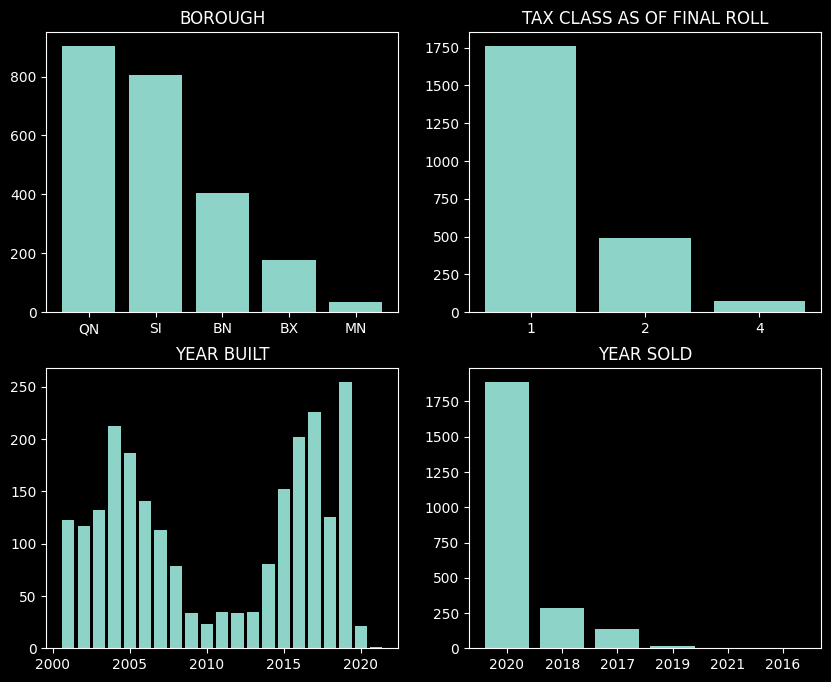

In [13]:
# Categorical Data
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2)

ax = ax.flatten()

categorical_col_lst = ['BOROUGH','TAX CLASS AS OF FINAL ROLL','YEAR BUILT','YEAR SOLD']

for i in range(4):
    ax[i].bar(df[categorical_col_lst[i]].value_counts().index,
              df[categorical_col_lst[i]].value_counts().values)
    ax[i].set_title(categorical_col_lst[i])

plt.show()

In [33]:
# Borough of Cash Transaction Sales by Percentage
df['BOROUGH'].value_counts(normalize=True) * 100

QN    38.841202
SI    34.592275
BN    17.424893
BX     7.639485
MN     1.502146
Name: BOROUGH, dtype: float64

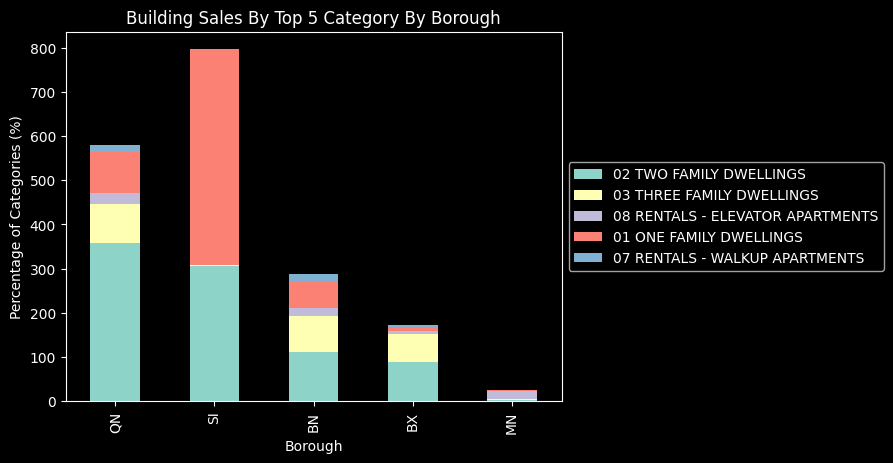

In [15]:
# Building Sales by Top 5 Building Class Category By Borough 
df_0 = pd.crosstab(df['BOROUGH'],df['BUILDING CLASS CATEGORY'])
top_5 = list(df[df['BOROUGH'] == 'BX']['BUILDING CLASS CATEGORY'].value_counts().head(5).index)

df_0[top_5].assign(sum=df_0.sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:,:-1].plot(kind='bar', stacked='True')

plt.title("Building Sales By Top 5 Category By Borough")
plt.xlabel("Borough")
plt.ylabel("Percentage of Categories (%)")
plt.grid(False)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

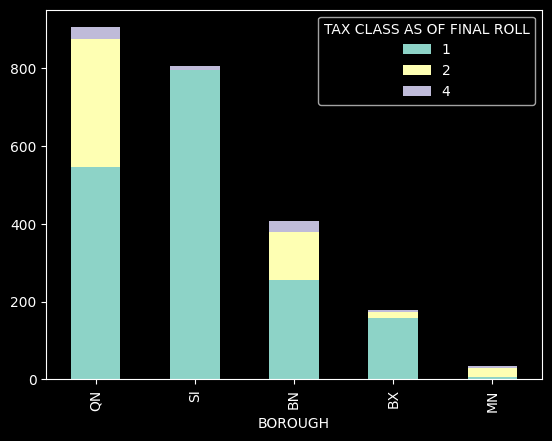

In [16]:
pd.crosstab(df['BOROUGH'],df['TAX CLASS AS OF FINAL ROLL']).assign(sum=df_0.sum(axis=1)).sort_values(by='sum', ascending=False).iloc[:,:-1].plot(kind='bar', stacked='True')
plt.show()

In [17]:
df['PRICE PER SQFT'].value_counts(bins=[50,100,500,1000,10000,100000])

(100.0, 500.0]         1583
(500.0, 1000.0]         290
(49.999, 100.0]         180
(1000.0, 10000.0]        49
(10000.0, 100000.0]       0
Name: PRICE PER SQFT, dtype: int64

In [18]:
df['PRICE PER SQFT'].describe()

count    2330.000000
mean      263.391820
std       484.866713
min         0.000006
25%       118.472103
50%       153.828426
75%       228.662067
max      9968.097222
Name: PRICE PER SQFT, dtype: float64

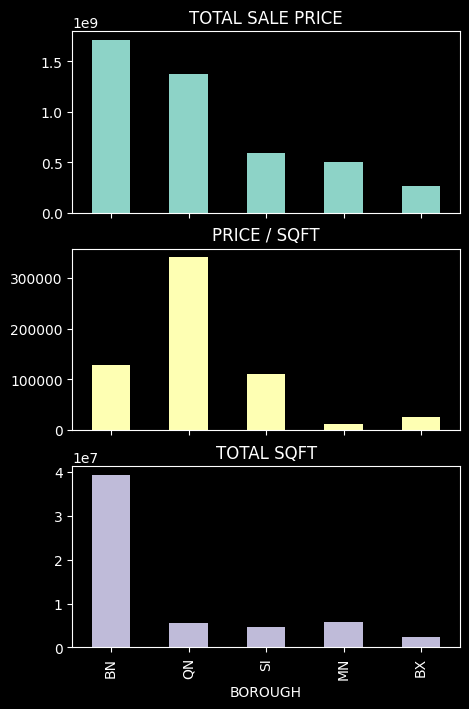

In [19]:
# Continuous Data

# Value of sold properties by BOROUGH
df_3 = pd.DataFrame({
    'TOTAL SALE PRICE' : df.groupby('BOROUGH')['SALE PRICE'].sum().sort_values(ascending=False),
    'PRICE / SQFT' : df.groupby('BOROUGH')['PRICE PER SQFT'].sum().sort_values(ascending=False),
    'TOTAL SQFT' : df.groupby('BOROUGH')['TOTAL SQFT'].sum().sort_values(ascending=False)
}).sort_values(by='TOTAL SALE PRICE', ascending=False)

df_3.plot(kind='bar', grid=False, subplots=True, sharex=True, legend=False, figsize=(5,8))
plt.show()

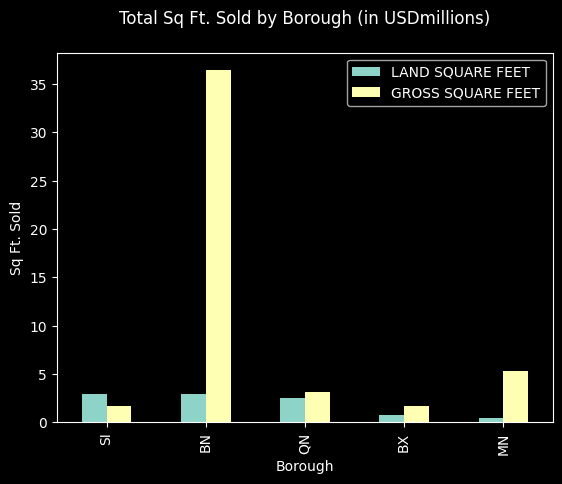

In [20]:
# Total square meters of properties sold by BOROUGH
df_2 = pd.DataFrame(columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET'])

df_2['GROSS SQUARE FEET'] = df.groupby('BOROUGH')['GROSS SQUARE FEET'].sum() / 1000000
df_2['LAND SQUARE FEET'] = df.groupby('BOROUGH')['LAND SQUARE FEET'].sum() / 1000000

df_2.sort_values('LAND SQUARE FEET', ascending=False)[['LAND SQUARE FEET','GROSS SQUARE FEET']].plot(kind='bar',stacked=False)

plt.title("Total Sq Ft. Sold by Borough (in USDmillions)\n", fontsize=12)
plt.xlabel("Borough")
plt.ylabel("Sq Ft. Sold")
plt.grid(False)

plt.show()

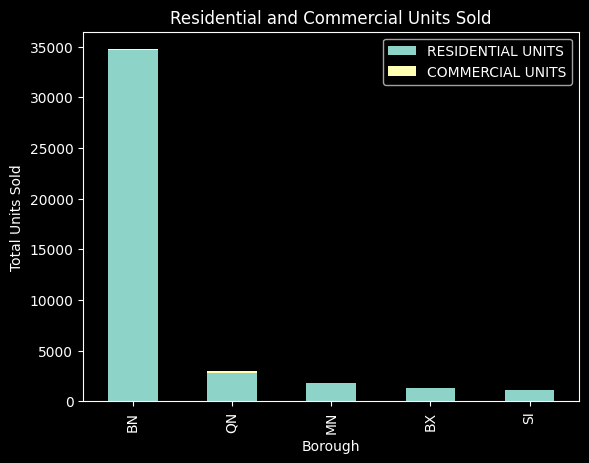

In [21]:
# Residential and Commercial Units Sold
df_1 = pd.DataFrame(columns = ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS','TOTAL UNITS'])

df_1['RESIDENTIAL UNITS'] = df.groupby('BOROUGH')['RESIDENTIAL UNITS'].sum()
df_1['COMMERCIAL UNITS'] = df.groupby('BOROUGH')['COMMERCIAL UNITS'].sum()
df_1['TOTAL UNITS'] = df.groupby('BOROUGH')['TOTAL UNITS'].sum()

df_1.sort_values('TOTAL UNITS', ascending=False)[['RESIDENTIAL UNITS','COMMERCIAL UNITS']].plot(kind='bar',stacked=True)

plt.title("Residential and Commercial Units Sold")
plt.grid(False)
plt.xlabel("Borough")
plt.ylabel("Total Units Sold")

plt.show()

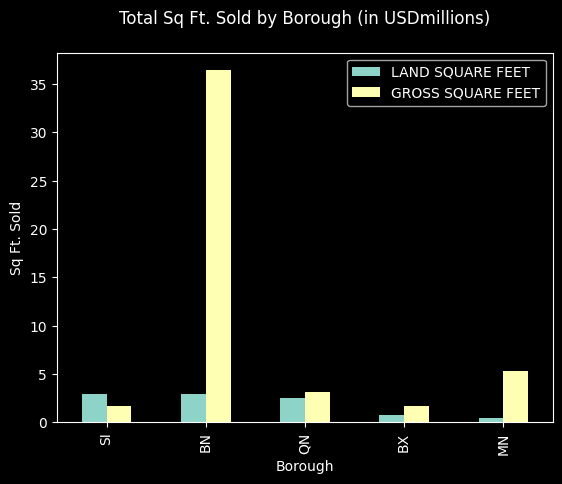

In [22]:
# Total square meters of properties sold by BOROUGH
df_2 = pd.DataFrame(columns = ['GROSS SQUARE FEET', 'LAND SQUARE FEET'])

df_2['GROSS SQUARE FEET'] = df.groupby('BOROUGH')['GROSS SQUARE FEET'].sum() / 1000000
df_2['LAND SQUARE FEET'] = df.groupby('BOROUGH')['LAND SQUARE FEET'].sum() / 1000000

df_2.sort_values('LAND SQUARE FEET', ascending=False)[['LAND SQUARE FEET','GROSS SQUARE FEET']].plot(kind='bar',stacked=False)

plt.title("Total Sq Ft. Sold by Borough (in USDmillions)\n", fontsize=12)
plt.xlabel("Borough")
plt.ylabel("Sq Ft. Sold")
plt.grid(False)

plt.show()

In [23]:
df[['RESIDENTIAL UNITS','COMMERCIAL UNITS','LAND SQUARE FEET','GROSS SQUARE FEET','SALE PRICE']].corr()

,RESIDENTIAL UNITS,COMMERCIAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,SALE PRICE
RESIDENTIAL UNITS,1.000000,-0.003422,0.596645,0.907309,0.054106
COMMERCIAL UNITS,-0.003422,1.000000,0.110204,0.034074,0.095143
LAND SQUARE FEET,0.596645,0.110204,1.000000,0.647131,0.372428
GROSS SQUARE FEET,0.907309,0.034074,0.647131,1.000000,0.147177
SALE PRICE,0.054106,0.095143,0.372428,0.147177,1.000000


In [24]:
df.to_csv('NYC_Data.csv')